In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from types import SimpleNamespace
from scipy.optimize import fsolve

from IHANKModel import IHANKModelClass
import figures 
import calculations

In [16]:
new_fig = False

# Expenditure grid 
e_list = np.linspace(0.3, 2.0, 100)

# Colors 
c = {'T': 'r', 'NT': 'b'}

# Parameteres 
# Bohnert et al. 2024

par_boppart = SimpleNamespace()
par_boppart.epsilon = 0.22
par_boppart.gamma = 0.405
par_boppart.nu = 0.585 
par_boppart.etaE = 0.1
par_boppart.alphaE = 0.05


par_bohnert = SimpleNamespace()
par_bohnert.epsilon = 0.18
par_bohnert.gamma = 0.29
par_bohnert.nu = 0.475
par_bohnert.etaE = 0.1
par_bohnert.alphaE = 0.05


par_non_homo_CES = SimpleNamespace()
par_non_homo_CES.epsilon = 0.18
par_non_homo_CES.gamma = 0.18
par_non_homo_CES.nu = 0.475
par_non_homo_CES.etaE = 0.1
par_non_homo_CES.alphaE = 0.05


# Homothetic epsilon = 0
par_hom = SimpleNamespace()
par_hom.epsilon = 0.0
par_hom.gamma = 0.18
par_hom.nu = 0.585

# Homothetic epsilon = 0
par_hom_close = SimpleNamespace()
par_hom_close.epsilon = 0.000000001
par_hom_close.gamma = 0.18
par_hom_close.nu =0.585


# Cubb douglas parameters gamma = epsilon = 0 
par_cd = SimpleNamespace()
par_cd.gamma = 0.00000001
par_cd.epsilon = 0.0000000001
par_cd.nu = 0.585

# non-homothetic CES parameters (gamma = epsilon)
par_ces = SimpleNamespace()
par_ces.gamma = 0.29
par_ces.epsilon = 0.29
par_ces.nu = 0.585




In [3]:
par_bohnert_low_ep = SimpleNamespace()
par_bohnert_low_ep.epsilon = par_bohnert.epsilon *0.5
par_bohnert_low_ep.gamma = 0.29
par_bohnert_low_ep.nu = 0.475
par_bohnert_low_ep.etaE = 0.1
par_bohnert_low_ep.alphaE = 0.05

In [4]:

# Plotting expenditure shares
c = {'T': 'r', 'NT': 'b'}

# Define your functions
def calc_CT(par, e, PT=1, PNT=1):
    CT = (e/PT)*(par.nu*(PNT/e)**par.epsilon*(PT/PNT)**par.gamma)
    return CT

def calc_CNT(par,e, PT=1, PNT=1):
    CNT = (e/PNT)*(1-par.nu*(PNT/e)**par.epsilon*(PT/PNT)**par.gamma)
    return CNT



def share_T(par,e, PT=1, PNT=1):
    CT = (e/PT)*(par.nu*(PNT/e)**par.epsilon*(PT/PNT)**par.gamma)
    CNT = (e/PNT)*(1-par.nu*(PNT/e)**par.epsilon*(PT/PNT)**par.gamma)  
    return CT/(CT+CNT) 

def share_NT(par, e, PT=1, PNT=1):
    CT = (e/PT)*(par.nu*(PNT/e)**par.epsilon*(PT/PNT)**par.gamma)
    CNT = (e/PNT)*(1-par.nu*(PNT/e)**par.epsilon*(PT/PNT)**par.gamma)  
    return CNT/(CT+CNT)

def exp_shareT(par,e, PT=1, PNT=1):
    omega_T = par.nu *(PNT/e)**par.epsilon*(PT/PNT)**par.gamma
    return omega_T

def exp_shareNT(par,e, PT=1, PNT=1):
    omega_NT = 1-par.nu *(PNT/e)**par.epsilon*(PT/PNT)**par.gamma
    return omega_NT

def utility_indirect(par,e, PT=1, PNT=1):
    utility = (1/par.epsilon) * ( (e/PNT)**par.epsilon -1) - (par.nu/par.gamma)*( (PT/PNT)**par.gamma -1)
    return utility

def mu_e(par,e, PT=1, PNT=1):
    mu_e = PNT**(-par.epsilon) * e**(- (1-par.epsilon))
    return mu_e
    
# mapar.
# nualy calculating mu_e to check if it is correct
def mu_e_maual(par,e, PT=1, PNT=1):
    utility = utility_indirect(e, PT, PNT, par.nu, par.epsilon, par.gamma)
    utility_plus_1 = utility_indirect(e*1.01, PT, PNT, par.nu, par.epsilon, par.gamma)
    mu_e = (utility_plus_1 - utility) / (0.01*e)
    return mu_e

def calc_cost_of_living(par, e, PT=1, PNT=1):

    omega_T = exp_shareT(par, e, PT=1, PNT=1)

    p_tilde = ((1-(par.epsilon*omega_T)/par.gamma)*PNT**par.gamma + ((par.epsilon*omega_T)/par.gamma)*PT**par.gamma)**(1/par.gamma)
    p_index = p_tilde**(par.gamma/par.epsilon)*PNT**(1-(par.gamma/par.epsilon))


    return p_index

def calc_cost_of_living_new_eq(par, e, PT=1, PNT=1):

    omega_T = exp_shareT(par, e, PT=1, PNT=1)

    # If epsilon = 0
    if par.epsilon == 0:
                # Limiting case as epsilon -> 0, with P_T,s = P_NT,s = 1
        rel_ratio = (PT / PNT) ** par.gamma
        exponent = omega_T * rel_ratio * (1 / par.gamma) * (rel_ratio - 1)
        p_index = PNT * np.exp(exponent)
    else:
        p_index = PNT *(1+omega_T*(par.epsilon/par.gamma)*((PT/PNT)**par.gamma-1))**(1/par.epsilon)

    return p_index


def calc_cost_of_living_diff(par, e, PT=1, PNT=1):

    p_index = calc_cost_of_living(par, e, PT, PNT)
    pct_change = (p_index - 1)*100    

    return pct_change

# Calculating the non constant elasticity of substitution
def calc_NCES(par, e, PT=1, PNT=1):

    elasticity = 1 - par.gamma - (par.nu*(PT/PNT)**par.gamma) / ( (e/PNT)**par.epsilon - par.nu*(PT/PNT)**par.gamma) * (par.gamma - par.epsilon)

    return elasticity

def calc_NCES_alt(par, e, PT=1, PNT=1):
    omega_T = exp_shareT(par, e, PT=1, PNT=1)
    omega_NT = exp_shareNT(par, e, PT=1, PNT=1)

    elasticity = 1 - par.gamma - (omega_T /omega_NT ) * (par.gamma - par.epsilon)

    return elasticity


def calc_E(par, e,  PT=1, PNT=1, PE=1):
    CT =  calc_CT(par, e, PT, PNT)
    # CES nested Energy 
    CE = par.alphaE * CT* (PE/PT)**par.etaE

    return CE


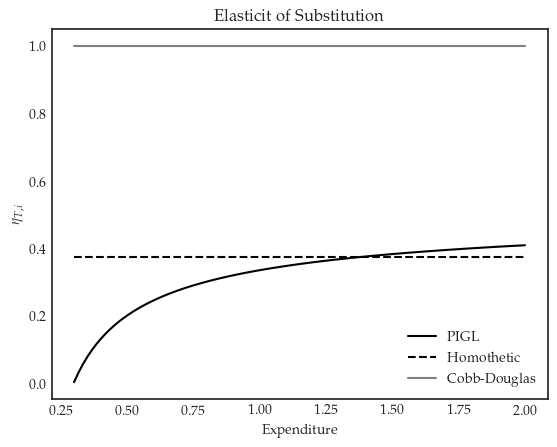

In [18]:
# Intretemporal elisticity of substitution

par_hom.gamma = 0.26

fig = plt.figure()

ax= fig.add_subplot(111)
# Coppy par borhert
# par_bohnert_gamma_high = SimpleNamespace()
# par_bohnert_gamma_high.epsilon = par_bohnert.epsilon
# par_bohnert_gamma_high.gamma = par_bohnert.epsilon
# par_bohnert_gamma_high.nu = par_bohnert.nu

# Utility over expenditure
ax.plot(e_list, calc_NCES(par_boppart, e_list), label='PIGL', c='k')
ax.plot(e_list, calc_NCES(par_hom, e_list), label='Homothetic ', c='k', linestyle='--')
# ax.plot(e_list, calc_NCES(par_hom, e_list), label='Homothetic$ ', c='k', linestyle='--')
ax.plot(e_list, calc_NCES(par_cd, e_list), label='Cobb-Douglas', c='grey')

ax.set_xlabel('Expenditure')
ax.set_ylabel('$\eta_{T,i}$')
ax.legend()
ax.set_title('Elasticit of Substitution')
plt.savefig('plots_defence/PIGL_NCES.png', dpi=300, bbox_inches='tight')
if new_fig: plt.savefig('plots/PIGL_NCES.png', dpi=300, bbox_inches='tight')

In [ ]:
# Combined 

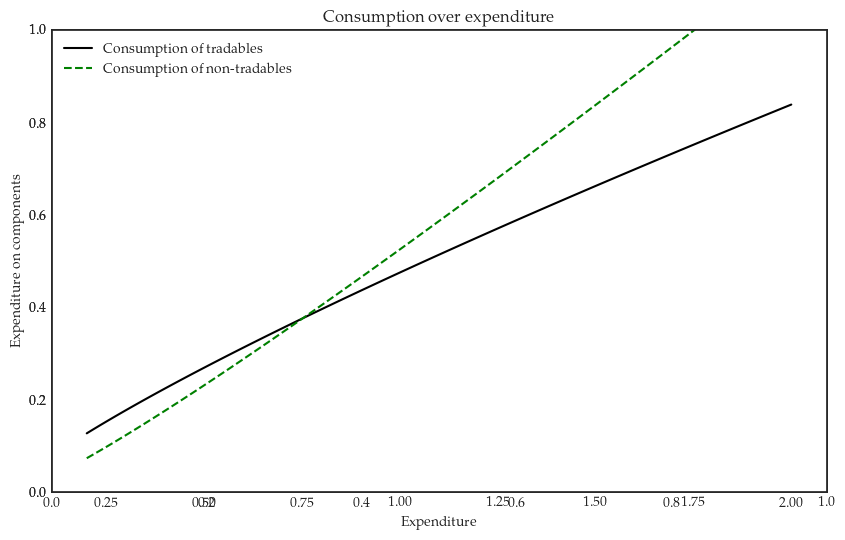

In [4]:
# fig, ax = plt.subplots()#figsize=(12, 8))
# fig, ax = plt.subplots()#figsize=(12, 8))
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()

ax= fig.add_subplot(111)

# coppy dictionary 
par_bohnert_epsilon_high = SimpleNamespace()
par_bohnert_epsilon_high.__dict__.update(par_bohnert.__dict__)
par_bohnert_epsilon_high.epsilon = par_bohnert.epsilon + 0.2

# Consumption shares over expenditure
ax.plot(e_list, calc_CT(par_bohnert, e_list), label='Consumption of tradables', c='k')
# ax.plot(e_list, calc_CT(par_bohnert_epsilon_high, e_list), label='Bohnert et al. 2024, $\epsilon$ + 0.2 ', c='k', linestyle='--')
# ax.plot(e_list, calc_CT(par_hom, e_list), label='Cobb-Douglas', c='grey', linestyle='--')

ax.plot(e_list, calc_CNT(par_bohnert, e_list), label='Consumption of non-tradables', c='g', linestyle = '--')
# ax.plot(e_list, calc_CT(par_bohnert_epsilon_high, e_list), label='Bohnert et al. 2024, $\epsilon$ + 0.2 ', c='k', linestyle='--')
# ax.plot(e_list, calc_CNT(par_hom, e_list), label='Cobb-Douglas', c='g', linestyle='--')


ax.set_xlabel('Expenditure')
ax.set_ylim(0,1)
ax.set_ylabel('Expenditure on components ')
ax.set_title('Consumption over expenditure')
ax.legend()
if new_fig: plt.savefig('plots/PIGL_consumption.png', dpi=300, bbox_inches='tight')

NameError: name 'par_bohnert_low_ep' is not defined

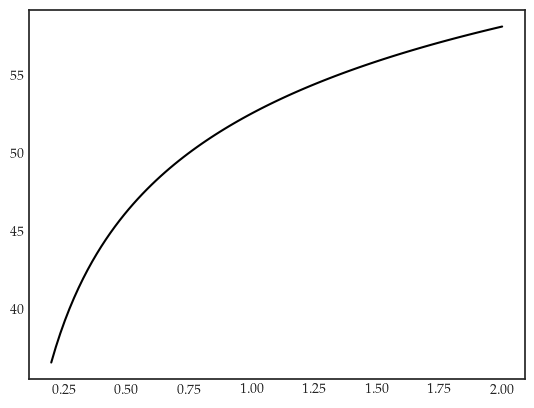

In [5]:
fig = plt.figure()

ax= fig.add_subplot(111)
# coppy dictionary 
par_bohnert_epsilon_high = SimpleNamespace()
par_bohnert_epsilon_high.__dict__.update(par_bohnert.__dict__)
par_bohnert_epsilon_high.epsilon = par_bohnert.epsilon + 0.2

# Consumption shares over expenditure
ax.plot(e_list, share_NT(par_bohnert, e_list)*100, label=f'PIGL ($\epsilon = {par_bohnert.epsilon}$)', c='k')
ax.plot(e_list, share_NT(par_bohnert_low_ep, e_list)*100, label=f'PIGL ($\epsilon = {par_bohnert_low_ep.epsilon}$)', c='k', linestyle='--')
ax.plot(e_list, share_NT(par_hom, e_list)*100, label=f'Homothetic ($\epsilon = 0$)', c='grey', linestyle='-')
ax.set_xlabel('Expenditure')
# ax.set_ylim(0,1)
ax.set_ylabel('Consumption share (\%)')
ax.set_title('Consumption share of tradables over expenditure')
ax.legend()
new_fig = True
if new_fig: plt.savefig('plots/PIGL_nontradable_consumption_share.png', dpi=300, bbox_inches='tight')

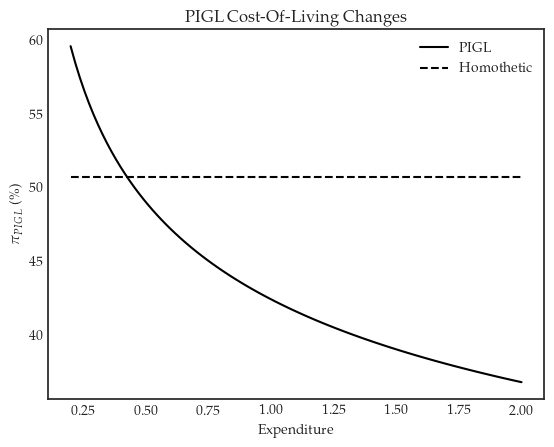

In [130]:
# Plotting IPP


fig = plt.figure()

ax= fig.add_subplot(111)


ax.plot(e_list, (calc_cost_of_living_new_eq(par_bohnert, e_list, PT = 2.0)-1)*100, label='PIGL ', c='k')
# ax.plot(e_list, (calc_cost_of_living_new_eq(par_bohnert_low_ep, e_list, PT = 2.0)-1)*100, label='PIGL,  $\epsilon \cdot 0.5$', c='grey', linestyle='--')
ax.plot(e_list, (calc_cost_of_living_new_eq(par_hom, e_list, PT = 2.0)-1)*100, label='Homothetic', c='k', linestyle='--')



# ax.plot(e_list, calc_cost_of_living_diff(par_hom_close, e_list, PT = 1.2), label='Cobb-Douglas', c='grey', linestyle='-')
ax.set_xlabel('Expenditure')
ax.set_title('PIGL Cost-Of-Living Changes')
ax.set_ylabel('$\pi_{PIGL}$ (\%)')
# ax.set_ylim(0,2)
ax.legend()
if new_fig: plt.savefig('plots/PIGL_COL.png', dpi=300, bbox_inches='tight')

In [107]:
par_hom.gamma = 0.21

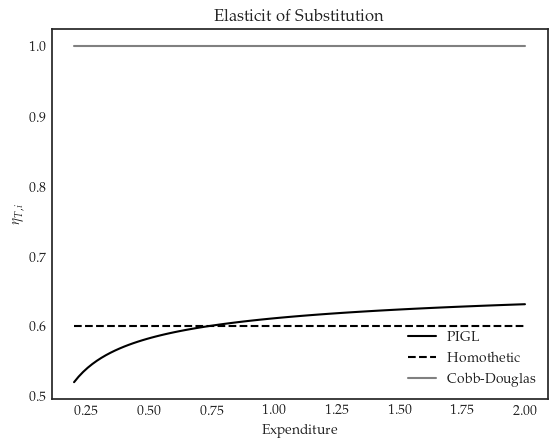

In [125]:
# Intretemporal elisticity of substitution

fig = plt.figure()

ax= fig.add_subplot(111)
# Coppy par borhert
# par_bohnert_gamma_high = SimpleNamespace()
# par_bohnert_gamma_high.epsilon = par_bohnert.epsilon
# par_bohnert_gamma_high.gamma = par_bohnert.epsilon
# par_bohnert_gamma_high.nu = par_bohnert.nu

# Utility over expenditure
ax.plot(e_list, calc_NCES(par_bohnert, e_list), label='PIGL', c='k')
ax.plot(e_list, calc_NCES(par_hom, e_list), label='Homothetic ', c='k', linestyle='--')
# ax.plot(e_list, calc_NCES(par_hom, e_list), label='Homothetic$ ', c='k', linestyle='--')
ax.plot(e_list, calc_NCES(par_cd, e_list), label='Cobb-Douglas', c='grey')

ax.set_xlabel('Expenditure')
ax.set_ylabel('$\eta_{T,i}$')
ax.legend()
ax.set_title('Elasticit of Substitution')

if new_fig: plt.savefig('plots/PIGL_NCES.png', dpi=300, bbox_inches='tight')

# Stop

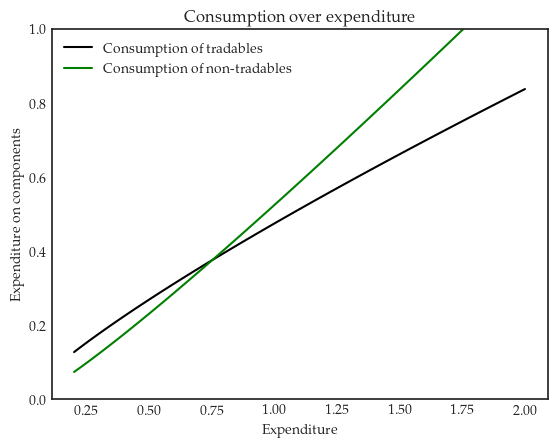

In [55]:
fig, ax = plt.subplots()#figsize=(12, 8))

# coppy dictionary 
par_bohnert_epsilon_high = SimpleNamespace()
par_bohnert_epsilon_high.__dict__.update(par_bohnert.__dict__)
par_bohnert_epsilon_high.epsilon = par_bohnert.epsilon + 0.2

# Consumption shares over expenditure
ax.plot(e_list, calc_CT(par_bohnert, e_list), label='Consumption of tradables', c='k')
# ax.plot(e_list, calc_CT(par_bohnert_epsilon_high, e_list), label='Bohnert et al. 2024, $\epsilon$ + 0.2 ', c='k', linestyle='--')
# ax.plot(e_list, calc_CT(par_cd, e_list), label='Cobb-Douglas', c='grey', linestyle='-')

ax.plot(e_list, calc_CNT(par_bohnert, e_list), label='Consumption of non-tradables', c='g')
# ax.plot(e_list, calc_CT(par_bohnert_epsilon_high, e_list), label='Bohnert et al. 2024, $\epsilon$ + 0.2 ', c='k', linestyle='--')
# ax.plot(e_list, calc_CNT(par_cd, e_list), label='Cobb-Douglas', c='g', linestyle='-')


ax.set_xlabel('Expenditure')
ax.set_ylim(0,1)
ax.set_ylabel('Expenditure on components ')
ax.set_title('Consumption over expenditure')
ax.legend()
if new_fig: plt.savefig('plots/PIGL_consumption.png', dpi=300, bbox_inches='tight')

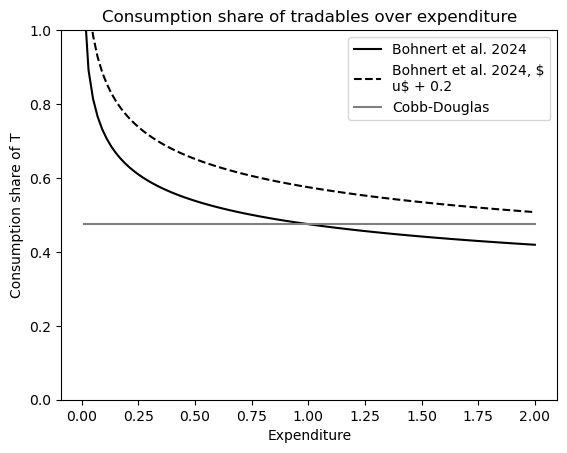

In [5]:
# Nu 

# Coppy par borhert
par_bohnert_nu_high = SimpleNamespace()
par_bohnert_nu_high.gamma = par_bohnert.gamma
par_bohnert_nu_high.epsilon = par_bohnert.epsilon 
par_bohnert_nu_high.nu = par_bohnert.nu + 0.1

fig, ax = plt.subplots()#figsize=(12, 8))

# Consumption shares over expenditure
ax.plot(e_list, share_T(par_bohnert, e_list), label='Bohnert et al. 2024', c='k')
ax.plot(e_list, share_T(par_bohnert_nu_high, e_list), label='Bohnert et al. 2024, $\nu$ + 0.2 ', c='k', linestyle='--')
ax.plot(e_list, share_T(par_cd, e_list), label='Cobb-Douglas', c='grey', linestyle='-')
ax.set_xlabel('Expenditure')
ax.set_ylim(0,1)
ax.set_ylabel('Consumption share of T')
ax.set_title('Consumption share of tradables over expenditure')
ax.legend()
if new_fig: plt.savefig('Figures/consumption_share_T_over_expenditure.png', dpi=300, bbox_inches='tight')

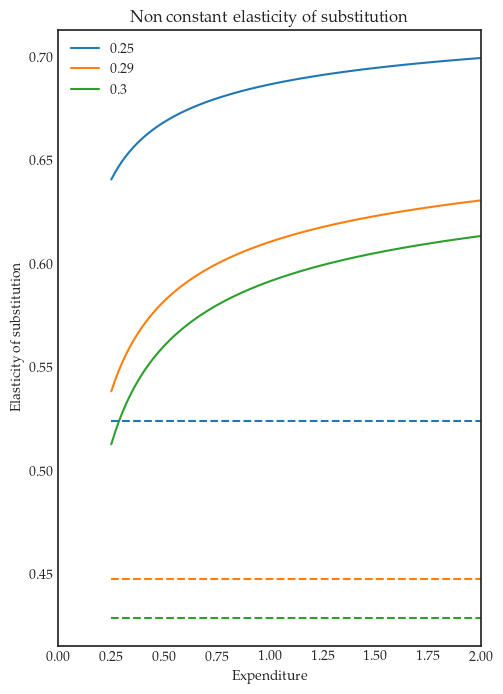

In [25]:
#calc_NCES
# Coppy par borhert
par_bohnert_gamma_high = SimpleNamespace()
par_bohnert_gamma_high.epsilon = par_bohnert.epsilon
par_bohnert_gamma_high.gamma = par_bohnert.gamma + 0.1
par_bohnert_gamma_high.nu = par_bohnert.nu

color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# fig, ax = plt.subplots()#figsize=(12, 8))

fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(121)
# alternative e starting at 0.25
e_alt = np.linspace(0.25, 2.0, 100)
# ax.plot(e_alt, calc_NCES(par_bohnert, e_alt), label='Bohnert et al. 2024', c='k')
# ax.plot(e_alt, calc_NCES(par_bohnert_gamma_high, e_alt), label='Bohnert et al. 2024, $\gamma + 0.1 $', c='k', linestyle='--')
# ax.plot(e_alt, calc_NCES(par_cd, e_alt), label='Cobb-Douglas', c='grey', linestyle='-')

par_ = par_bohnert
par_.epsilon = 0.18
# for gamma_i, in [0.1, 0.18, 0.2, 0.3, 0.4]:
#     par_.gamma = gamma_i
#     ax.plot(e_alt, calc_NCES(par_, e_alt), label=f'{gamma_i}', )

num = [0.25, 0.29, 0.3]

# add different colors 
for i, gamma_i in enumerate(num):
    par_.gamma = gamma_i
    ax.plot(e_alt, calc_NCES(par_, e_alt), label=f'{gamma_i}', c=color_list[i])

# ax.set_ylim(0, 0.8)

# e_alt = np.linspace(0.25, 2.0, 100)
# ax.plot(e_alt, calc_NCES_alt(par_bohnert, e_alt), label='Bohnert et al. 2024', c='r', linestyle='--')
# ax.plot(e_alt, calc_NCES_alt(par_bohnert_gamma_high, e_alt), label='Bohnert et al. 2024, $\gamma + 0.1 $', c='r', linestyle='--')
# ax.plot(e_alt, calc_NCES_alt(par_cd, e_alt), label='Cobb-Douglas', c='r', linestyle='--')



ax.set_xlabel('Expenditure')
ax.set_ylabel('Elasticity of substitution')
ax.legend()
ax.set_xlim(0.0, 2.0)
ax.set_title('Non constant elasticity of substitution')

# ax = fig.add_subplot(112)
par_.epsilon = 0.0 
# add different colors 
for i, gamma_i in enumerate(num):
    par_.gamma = gamma_i
    ax.plot(e_alt, calc_NCES(par_, e_alt), label=f'{gamma_i}', c=color_list[i], linestyle='--')

ax.set_xlabel('Expenditure')
ax.set_ylabel('Elasticity of substitution')
# ax.legend()

# ax.set_ylim(0, 0.8)


if new_fig: plt.savefig('Figures/elicitcity_of_substitution.png', dpi=300, bbox_inches='tight')

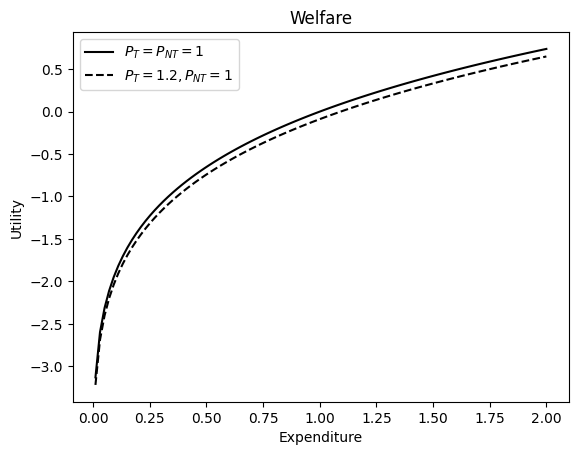

In [17]:
#Welfare change utility_indirect
fig, ax = plt.subplots()#figsize=(12, 8))
ax.plot(e_list, utility_indirect(par_bohnert, e_list), label='$P_T = P_{NT} = 1$', c='k')
ax.plot(e_list, utility_indirect(par_bohnert, e_list, PT = 1.2), label='$P_T = 1.2,   P_{NT} = 1$', c='k', linestyle='--')

ax.set_ylabel('Utility')
ax.set_xlabel('Expenditure')
ax.set_title('Welfare')
ax.legend()
if new_fig: plt.savefig('Figures/utility_change.png', dpi=300, bbox_inches='tight')

# I want to calculate how much expenditure is needed to compensate for a price increase

# Calculate the expenditure needed to compensate for the price increase


C:\Users\kons-efg\AppData\Local\Temp\ipykernel_11132\1159119338.py:10: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  E1 = fsolve(solve_E1, e)[0]  # Start with the initial guess of e


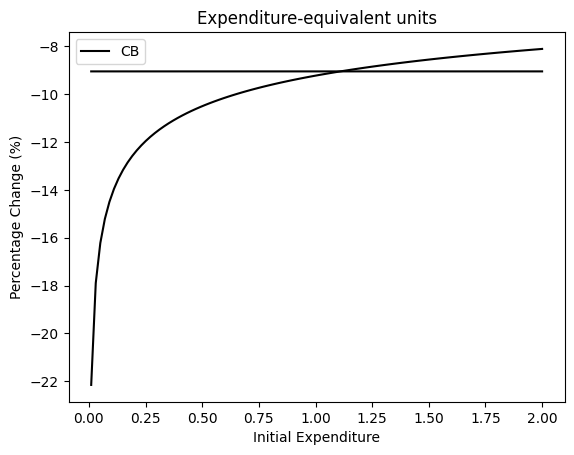

In [18]:
def compensating_variation(par, e, PT_before, PNT_before, PT_after, PNT_after):
    # Calculate baseline utility
    U0 = utility_indirect(par, e, PT=PT_before, PNT=PNT_before)
    
    # Define the function to solve for compensated expenditure
    def solve_E1(E1):
        return (1/par.epsilon) * ((E1/PNT_after)**par.epsilon - 1) - (par.nu/par.gamma) * ((PT_after/PNT_after)**par.gamma - 1) - U0
    
    # Use fsolve to find E1
    E1 = fsolve(solve_E1, e)[0]  # Start with the initial guess of e
    
    # Calculate percentage change in compensated expenditure
    pct_change = ((e -E1 ) / e) * 100  # Percentage change
    
    return E1, pct_change

# Define a range of expenditure levels
expenditure_levels = e_list #np.linspace(50, 500, 100)  # Example range of expenditure levels
PT_before = 1
PNT_before = 1
PT_after = 1.2
PNT_after = 1.0

# Initialize list to store percentage changes
compensation_pct_changes = []

# Plot the results
fig, ax = plt.subplots()#figsize=(12, 8))

# Compute percentage change in CV for each expenditure level
for e in expenditure_levels:
    _, pct_change = compensating_variation(par_bohnert, e, PT_before, PNT_before, PT_after, PNT_after)
    compensation_pct_changes.append(pct_change)

ax.plot(expenditure_levels, compensation_pct_changes, label='', c='k')

# Initialize list to store percentage changes
compensation_pct_changes = []
for e in expenditure_levels:
    _, pct_change = compensating_variation(par_cd, e, PT_before, PNT_before, PT_after, PNT_after)
    compensation_pct_changes.append(pct_change)

ax.plot(expenditure_levels, compensation_pct_changes, label='CB', c='k')

# Percentage Change in Compensation
#ax.plot(expenditure_levels, compensation_pct_changes, label='', c='k')

ax.set_xlabel('Initial Expenditure')
ax.set_ylabel('Percentage Change (%)')
ax.set_title('Expenditure-equivalent units')
ax.legend()
if new_fig: plt.savefig('Figures/compensated_expenditure.png', dpi=300, bbox_inches='tight')


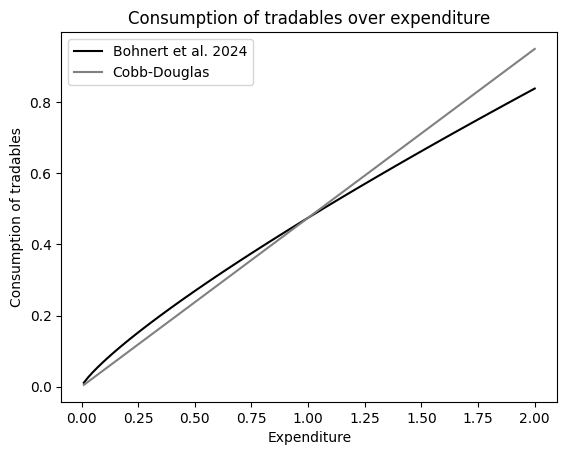

In [19]:
# consumption of tradables over expenditure
fig, ax = plt.subplots()#figsize=(12, 8))
ax.plot(e_list, calc_CT(par_bohnert, e_list), label='Bohnert et al. 2024', c='k')
ax.plot(e_list, calc_CT(par_cd, e_list), label='Cobb-Douglas', c='grey', linestyle='-')
ax.set_xlabel('Expenditure')
ax.set_ylabel('Consumption of tradables')
ax.set_title('Consumption of tradables over expenditure')
ax.legend()


# Other stufff

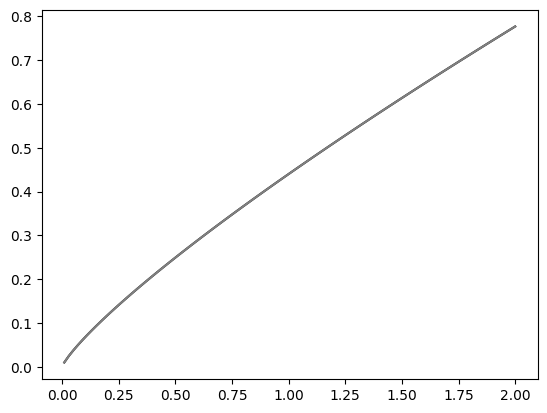

In [47]:
# Check it works 

def calc_CNT(par,e, PT=1, PNT=1):
    CNT = (e/PNT)*(1-par.nu*(PNT/e)**par.epsilon*(PT/PNT)**par.gamma)
    return CNT

def calc_CNT_tilde(par, e, PT=1, PNT=1):
    e_tilde = e/PNT
    p = PT/PNT
    CNT = e_tilde*(1-par.nu*(e_tilde)**(-par.epsilon)*(p)**par.gamma)
    return CNT

def calc_CT_tilde(par, e, PT=1, PNT=1):
    e_tilde = e/PNT
    p = PT/PNT
    CT = e_tilde*p**(-1)*par.nu*(e_tilde)**(-par.epsilon)*(p)**par.gamma
    return CT


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(e_list, calc_CT_tilde(par_bohnert, e_list, PNT = 2.0), label='Bohnert et al. 2024', c='k')
ax.plot(e_list, calc_CT(par_bohnert, e_list, PNT = 2.0), label='Cobb-Douglas', c='grey', linestyle='-')

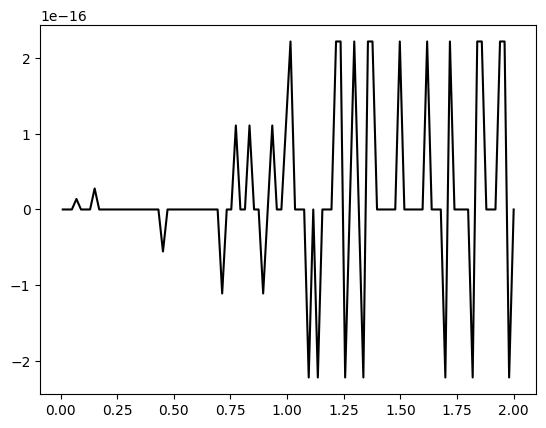

In [48]:
# Checking consumption = expenditure
fig = plt.figure()
ax = fig.add_subplot(111)

#residual = 2*calc_CT(par_bohnert, e_list, PT=2) + calc_CNT(par_bohnert, e_list,PT=2) - e_list


residual_tilde = calc_CT_tilde(par_bohnert, e_list)+ calc_CNT_tilde(par_bohnert, e_list, PT=1, PNT=1) - e_list


#residual_tilde = calc_CT_tilde(par_bohnert, e_list) + calc_CNT_tilde(par_bohnert, e_list) 

ax.plot(e_list, residual_tilde, label='Bohnert et al. 2024', c='k')

Text(0.5, 1.0, 'Inequality in Cost of living')

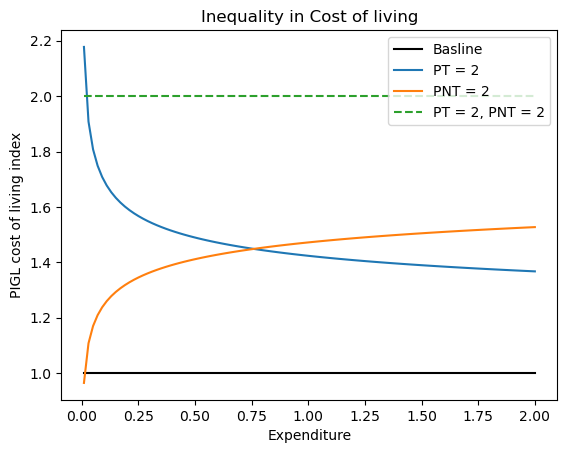

In [7]:
# *** Stort problem 

# Utility over expenditure
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(e_list, calc_cost_of_living(par_bohnert, e_list), label='Basline', c='k')
ax.plot(e_list, calc_cost_of_living(par_bohnert, e_list, PT=2.0), label='PT = 2')
ax.plot(e_list, calc_cost_of_living(par_bohnert, e_list, PNT=2.0), label='PNT = 2')
ax.plot(e_list, calc_cost_of_living(par_bohnert, e_list, PT=2.0, PNT=2.0), label='PT = 2, PNT = 2', linestyle='--')

ax.set_xlabel('Expenditure')
ax.set_ylabel('PIGL cost of living index')
ax.legend()
ax.set_title('Inequality in Cost of living')

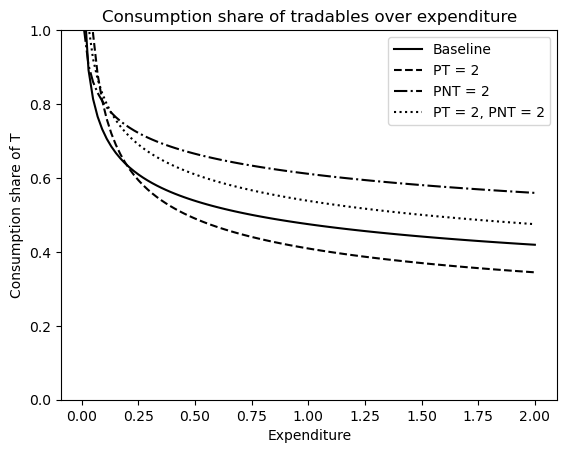

In [16]:
fig, ax = plt.subplots()#figsize=(12, 8))

# Consumption shares over expenditure
ax.plot(e_list, share_T(par_bohnert, e_list), label='Baseline', c='k')
ax.plot(e_list, share_T(par_bohnert, e_list, PT=2.0), label='PT = 2', linestyle='--', c='k')
ax.plot(e_list, share_T(par_bohnert, e_list, PNT=2.0), label='PNT = 2', linestyle='-.', c='k')
ax.plot(e_list, share_T(par_bohnert, e_list, PT=2.0, PNT=2.0), label='PT = 2, PNT = 2', linestyle=':', c='k')

ax.set_xlabel('Expenditure')
ax.set_ylim(0,1)
ax.set_ylabel('Consumption share of T')
ax.set_title('Consumption share of tradables over expenditure')
ax.legend()
if new_fig: plt.savefig('Figures/consumption_share_T_over_expenditure.png', dpi=300, bbox_inches='tight')

In [30]:
import time
import sys

def slow_print(text, delay=0.05):
    for char in text:
        sys.stdout.write(char)
        sys.stdout.flush()
        time.sleep(delay)
    print()

def browse():
    slow_print('Welcome to the Browse function!')
    slow_print('This is probably the best function ever!')
    slow_print('Congratulations for using it!')

browse()


Welcome to Browse function!
This is probably the best function ever!
Congratulations for using it!


(0.0, 1.0)

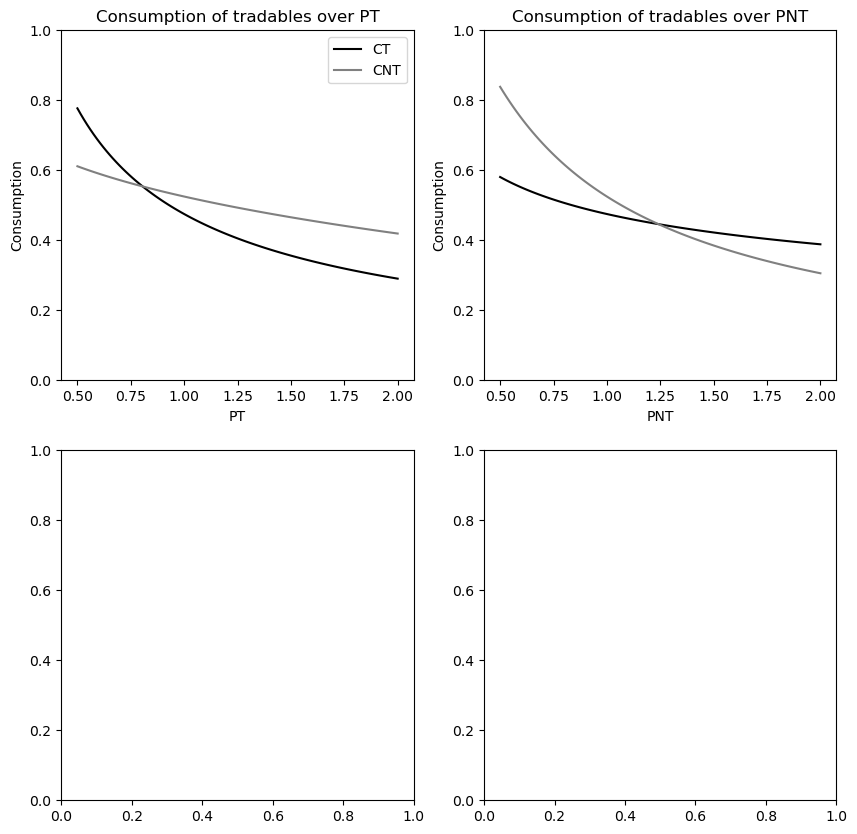

In [7]:
# non-homothetic CES par_newameters (gamma = epsilon)
par_new = SimpleNamespace()
par_new.gamma = 0.29
par_new.epsilon = 0.0
par_new.nu = 0.475 


PT_list = np.linspace(0.5, 2.0, 100)
PNT_list = np.linspace(0.5, 2.0, 100)

# 4X 4 plot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# CT over PT 
axs[0, 0].plot(PT_list, calc_CT(par_new, 1, PT=PT_list), label='CT', c='k')
axs[0, 0].plot(PT_list, calc_CNT(par_new, 1, PT=PT_list), label='CNT', c='grey')
axs[0, 0].set_xlabel('PT')
axs[0, 0].set_ylabel('Consumption')
axs[0, 0].set_title('Consumption of tradables over PT')
axs[0,0].set_ylim(0, 1)
axs[0, 0].legend()

# CT over PNT
axs[0, 1].plot(PNT_list, calc_CT(par_new, 1, PNT=PNT_list), label='CT', c='k')
axs[0, 1].plot(PNT_list, calc_CNT(par_new, 1, PNT=PNT_list), label='CNT', c='grey')
axs[0, 1].set_xlabel('PNT')
axs[0, 1].set_ylabel('Consumption')
axs[0, 1].set_title('Consumption of tradables over PNT')
axs[0,1].set_ylim(0, 1)

# Expenditure over PT
